# S2 CNN position reconstruction training on WFsim patterns

by Andrii Terliuk, 28.05.2020

This notebook shows an example of CNN training for position reconstruction of S2 signals using the simulations from WFsim

In [1]:
import os
import sys
import ast
import glob
import h5py
import numpy as np
import pandas as pd
import concurrent.futures
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as colors
from importlib import reload

import matplotlib.cm as cm
from copy import deepcopy
colormap = deepcopy(cm.YlGn)
colormap.set_under("w")

%matplotlib inline

### Loading plotter to plot an array 

In [2]:
sys.path.append("/home/terliuk/XENONscripts/WFsim_pattern_gen/")
from plot_patterns import plot_one_array, plot_pattern

### Loading files for training
WARING: this might requre a lot of RAM, make sure that your job has enough allocated recourses 

In [3]:
config = "A_const_10__Z_const_-1"
nevents = 10000 # this identifies files
nfiles = 50 # and number of files to read
wfsim_mode="disk_const_PE"

infolder = "/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/%s/%s/"%(wfsim_mode,config)
allfiles = glob.glob(infolder+"WFsim_%s_N%d_*.hdf5"%(config, nevents))
allfiles.sort()
positions = np.zeros((0,3))
patterns = np.zeros((0,494))
for onefname in allfiles[0:nfiles]:
    print(onefname)
    onefile = h5py.File(onefname,"r")
    patterns = np.concatenate([patterns, np.array(onefile['area_per_channel'])])
    positions = np.concatenate([positions, np.array(onefile['corr_pos'])])
positions = positions*10. # converting to mm

/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_const_PE/A_const_10__Z_const_-1/WFsim_A_const_10__Z_const_-1_N10000_000000.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_const_PE/A_const_10__Z_const_-1/WFsim_A_const_10__Z_const_-1_N10000_000001.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_const_PE/A_const_10__Z_const_-1/WFsim_A_const_10__Z_const_-1_N10000_000002.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_const_PE/A_const_10__Z_const_-1/WFsim_A_const_10__Z_const_-1_N10000_000003.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_const_PE/A_const_10__Z_const_-1/WFsim_A_const_10__Z_const_-1_N10000_000004.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_const_PE/A_const_10__Z_const_-1/WFsim_A_const_10__Z_const_-1_N10000_000005.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_const_PE/A_const_10__Z_const_-1/WFsim_A_const_10__Z_const_-1_N10000_000006.hdf5
/project2/lgrandi/terliuk/MCoutputs/WFsim_patter

### Loading PMT positions for plotting
Alternatively, use straxen.pmt_positions(). I do it since in my GPU environment I do not have straxen installed

In [4]:
pmtpos = pickle.load(open("/project2/lgrandi/terliuk/PMTpositions.pckl","rb")) 
n_PMT_top=np.sum(pmtpos['array']=="top")

#### Providing normalixation and transformation
maxnorm  PMT with maximal signal will be considered 1 and othets scaled accordingly
dw or doublewidth correspond to double widht transformation of HEX to cartesian

In [5]:
norm = "maxnorm"
transformation = "dw"

#### Loading pattern converter 
it converts vector of PMT areas into the desired 2D map

In [6]:
sys.path.append("/project2/lgrandi/terliuk/CNNmodels/")
import PatternConverter
converter = PatternConverter.PatternConverter(model =transformation)

And converting the templates

In [7]:
patterns_all = [None] * patterns.shape[0]
for iev in range(0, patterns.shape[0]):
    if norm=="maxnorm":
        patterns_all[iev]  = converter.convert_pattern(patterns[iev][0:n_PMT_top]/
                                             np.max(patterns[iev][0:n_PMT_top]))
patterns_all = np.array(patterns_all)

#### Sanity checks
Checking that injected position and patterns roughly match for a few figures

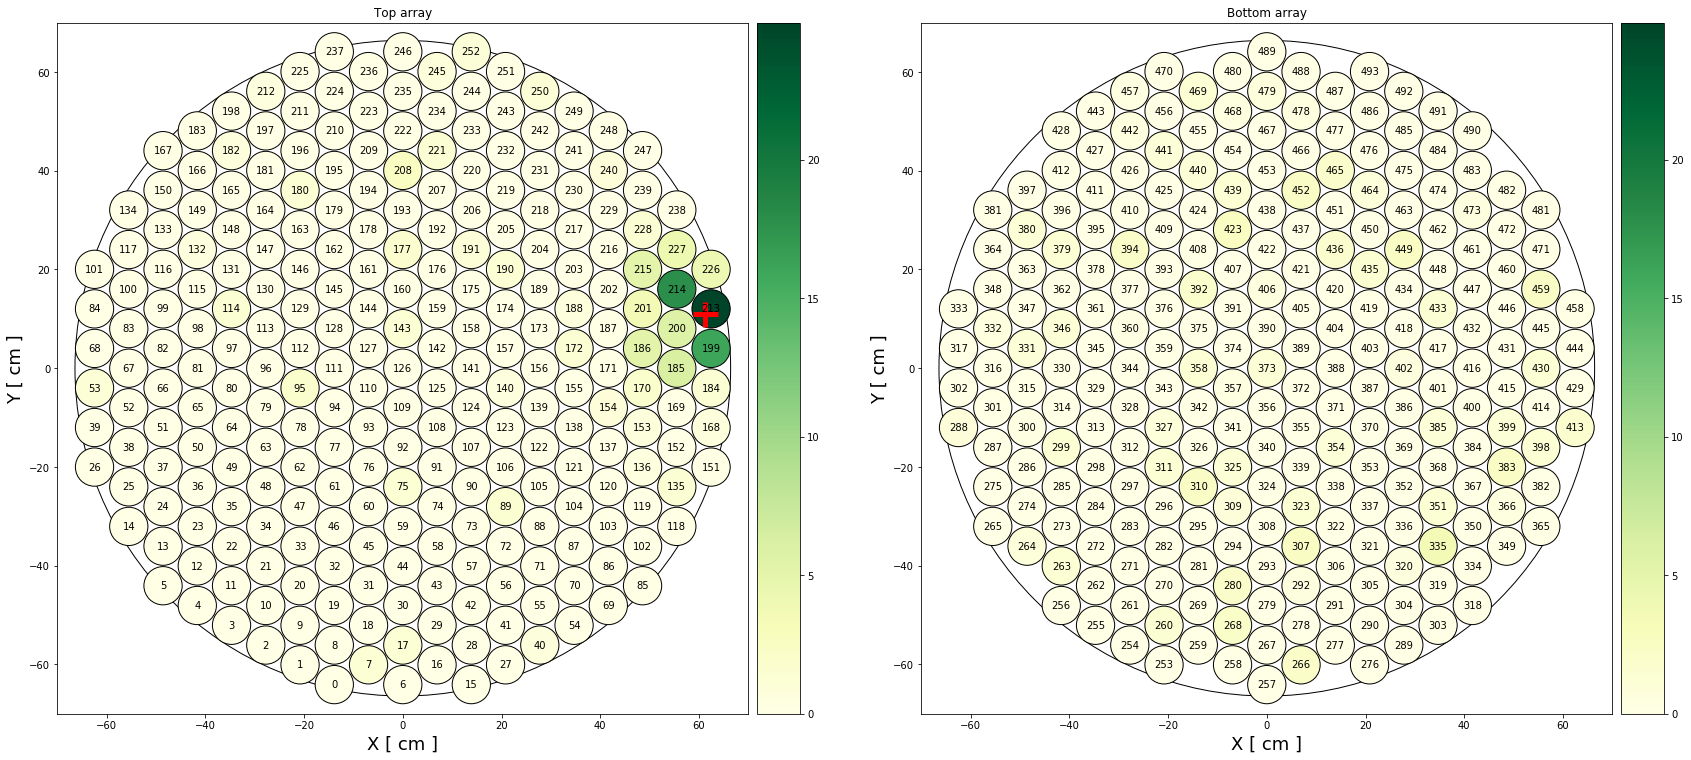

In [8]:
evt = int(np.round( np.random.uniform(0, patterns.shape[0]-1)) )
fig, axes = plot_pattern(patterns[evt],pmtpos,cmap = colormap)

axes['ax_top'].plot(positions[evt][0]/10., positions[evt][1]/10., marker = "+", 
                    ms=25, color="r",mew=5)
pass

#### Plotting the pattern after transformation
Note, that CNN is done in rotated coordinates, assuming that X axis goes along the line PMT 118-134
This is done to simplify transformation mathematics. Typically, neural nets should be agnostic to rotation or other linear transformations, as long as the same one applied during training and application. 

Text(0, 0.5, 'Row Y')

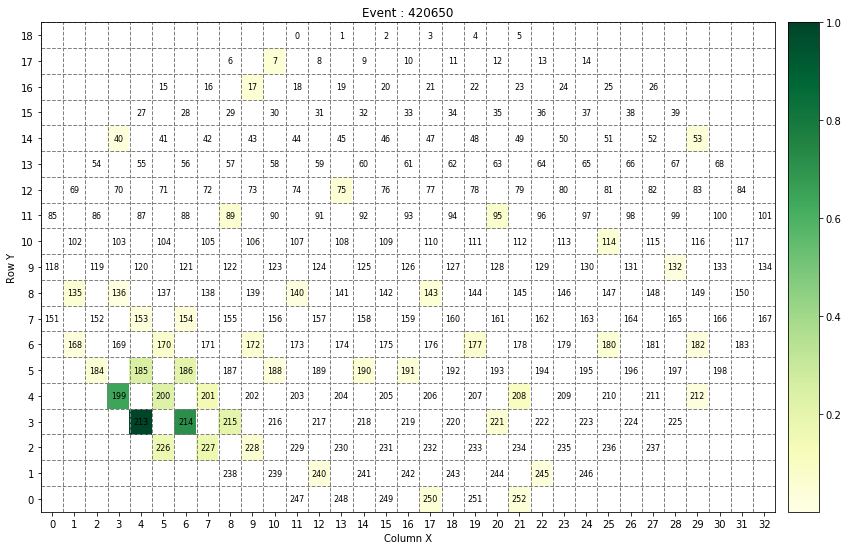

In [9]:
pattern = patterns_all[evt]

xedges = np.linspace(-0.5, pattern.shape[0]-0.5, pattern.shape[0]+1)
yedges = np.linspace(-0.5, pattern.shape[1]-0.5, pattern.shape[1]+1)

####
fig = plt.figure(figsize=(12,8), facecolor = "w")
ax = fig.add_axes([0.08, 0.08, 0.85, 0.85])
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])
ax.set_xticks(xedges[0:-1]+0.5)
ax.set_yticks(yedges[0:-1]+0.5)
ax.set_title("Event : %d"% evt)

ax.vlines(xedges, ymin=yedges.min(), ymax=yedges.max(), 
          linestyles ="dashed", color = "0.5", linewidth=1)
ax.hlines(yedges, xmin=xedges.min(), xmax=xedges.max(), 
          linestyles ="dashed", color = "0.5", linewidth=1)

cvals = ax.pcolor(xedges, yedges, pattern.T,cmap = colormap, vmin=1e-10)
cbar_ax = fig.add_axes([0.945,0.08,0.035,0.85])
cbar_bottom = plt.colorbar(cvals, cax = cbar_ax)
coords = converter.get_coordinates()
for i in range(0, 253):
    ax.text( coords[i][0],coords[i][1],"%d"%i, va="center", ha="center", fontsize=8)
ax.set_xlabel("Column X")
ax.set_ylabel("Row Y")

In [10]:
import tensorflow as tf
from tensorflow import keras
print("TF version: " , tf.__version__)
#print("GPU available : ", tf.test.is_gpu_available())

TF version:  2.1.0


#### Making training and validations sets with 80/20 split

In [11]:
test_frac = 0.20
n_test = np.int(patterns_all.shape[0]*test_frac)

In [12]:
patterns_test = patterns_all[:n_test:]
patterns_train = patterns_all[n_test::]
all_pos = positions[:,0:2]

test_pos = np.copy(all_pos[:n_test:])
train_pos =  np.copy(all_pos[n_test::])

### Creating model 
Currently model consists of layers : 

1. 2D convolution layer with size (13,7) to account stretched patterns along X axis
2. 2D conv layer with kernel size 5
3. 2D conv layer with kernel size 5
4. Maximal pooling with size 3x2
5. Dense layer with 8 neurons
6. Output layer for 2 coordinates (x,y)

Intermediate padding layers are added to keep the size of the image/pattern the same and to avoid extreme edge effects. 

In [13]:
model = keras.models.Sequential()

model.add(keras.layers.Reshape(target_shape=(33,19,1), 
                     input_shape=(33,19)))
model.add(tf.keras.layers.ZeroPadding2D(padding=(6, 3)))
model.add(keras.layers.Conv2D(16,kernel_size=(13,7), strides = (1,1), 
                              activation='elu'))
model.add(tf.keras.layers.ZeroPadding2D(padding=(2 ,2)))
model.add(keras.layers.Conv2D(32,kernel_size=5, strides = (1,1), 
                              activation='elu'))
model.add(tf.keras.layers.ZeroPadding2D(padding=(2 ,2)))
model.add(keras.layers.Conv2D(32,kernel_size=5, strides = (1,1), 
                              activation='elu'))
model.add(keras.layers.MaxPooling2D(pool_size=(3, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8, activation='elu'))
model.add(keras.layers.Dense(2, activation='linear'))
model.compile(loss='mean_squared_error',
              optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 33, 19, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 45, 25, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 33, 19, 16)        1472      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 37, 23, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 19, 32)        12832     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 37, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 19, 32)        2

#### Training the net 
Number for batch size and epochs is very preliminary and can be further optimized

In [ ]:
batch_size =500
epochs = 250

hist = model.fit(patterns_train, train_pos, 
                 batch_size = batch_size, 
                 validation_data = (patterns_test,test_pos),
                 epochs = epochs, 
                 verbose = 1)

Train on 399936 samples, validate on 99983 samples
Epoch 1/250
399936/399936 [==============================] - 75s 186us/sample - loss: 6628.6767 - val_loss: 527.0941
Epoch 2/250
399936/399936 [==============================] - 59s 147us/sample - loss: 367.5016 - val_loss: 278.6292
Epoch 3/250
399936/399936 [==============================] - 59s 148us/sample - loss: 251.2565 - val_loss: 226.1945
Epoch 4/250
399936/399936 [==============================] - 60s 149us/sample - loss: 209.7013 - val_loss: 191.2607
Epoch 5/250
399936/399936 [==============================] - 60s 149us/sample - loss: 185.8805 - val_loss: 181.6804
Epoch 6/250
399936/399936 [==============================] - 60s 149us/sample - loss: 169.2957 - val_loss: 154.8074
Epoch 7/250
399936/399936 [==============================] - 60s 150us/sample - loss: 158.2250 - val_loss: 154.8982
Epoch 8/250
399936/399936 [==============================] - 60s 149us/sample - loss: 147.9913 - val_loss: 149.7846
Epoch 9/250
399936/3

#### Saving the model for further application

In [ ]:
savefname ="/project2/lgrandi/terliuk/CNNmodels/CNN_defaults/%s/CNN_%s_%s_v2_3L_%s.hdf5"%(wfsim_mode,transformation, norm,config)

In [ ]:
print(savefname)
model.save(savefname)

#### Plotting the training and validation loss

In [ ]:
x = np.linspace(1, epochs, epochs)
x = np.linspace(1,len(hist.history['loss']),len(hist.history['loss']))
val_loss = hist.history['val_loss']
loss = hist.history['loss']

fig_sig= plt.figure(figsize = (15,12), facecolor="w")

#--------------------------------------------------------------------->
plt.plot(x,loss,label='training loss', color='blue', linestyle = '-', lw=2)
plt.plot(x,val_loss,label='validation loss', color='red', linestyle = '-', lw=2)
#-------------------------------------------------------------------->
# plt.title(r'Fig 3: Training Process', fontsize = 20)
plt.xlim(0,epochs)
plt.ylim(0, 200)

plt.xlabel('Epoch')
plt.ylabel('Loss [MSE, mm${}^2$]')
plt.grid(True)

# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.yticks(np.linspace(0,50,11))
#plt.yticks(np.linspace(0,200,11))

plt.xticks(np.linspace(0, epochs, int(np.ceil(epochs/25 + 1))) )
#plt.xticks(np.linspace(0,300,31))
legend = plt.legend(loc='upper right',fontsize=18)
#plt.show()
fig_sig.savefig(savefname.replace(".hdf5", ".png"))

#### Plotting some preliminary position precision

In [ ]:
pred_pos = model.predict(patterns_test)

In [ ]:
plt.figure(figsize = (8,6))
plt.hist2d(test_pos[:,0]-pred_pos[:,0], test_pos[:,1]-pred_pos[:,1], norm=matplotlib.colors.LogNorm(),
           range=((-40, 40), (-40, 40)),bins=(200, 200))
plt.colorbar()

plt.axvline(0, color='black', linestyle='-', linewidth = 1.5)
plt.axvline(-10, color='black', linestyle='--', linewidth = 1.5)
plt.axvline(10, color='black', linestyle='--', linewidth = 1.5)

plt.axhline(0, color='black', linestyle='-', linewidth = 1.5)
plt.axhline(-10, color='black', linestyle='--', linewidth = 1.5)
plt.axhline(10, color='black', linestyle='--', linewidth = 1.5)
plt.show()

print("Average error is",np.sum(test_pos-pred_pos,axis = 0) / len(test_pos))
print("RMS: ", np.std(test_pos-pred_pos,axis = 0))